In [1]:
#qiskit 0.45.2
pip install qiskit


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
from qiskit import QuantumCircuit, BasicAer, transpile

def get_qcbm_circuit(n: int, m: int, layers: int, parameters: list) -> QuantumCircuit:
    """
    n: amount of variables
    m: qubits per variable
    layers: amount of unitary transformation layers
    parameters: the parameters of the unitary transformation to be optimized 
    For simplicity, all unitary gate use the same parameters. Witone parameter for the RZ agte, another for the RX and all RZZ gates using the same theta.
    Each variable should use their own parameters in the future

    returns: qiskit QuantumCircuit object, sample of unitary transformation circuit
    """
    qc = QuantumCircuit(n*m, name="QCBM")
    
    # H on the qubits of the first variable
    qc.h(range(0, m)) 

    # CNOT using variable 1 qubit's as control on all the qubits of the other variables
    for i in range(1, n):
        for j in range(0, m):
            qc.cx(j, i*m+j) # control is the qubit on variable 1, target is the qubit on the variable i
            
    # Build Ui for each variable
    for i in range(0, n):
        qc_u = QuantumCircuit(m, name=f"U{i}")
        for j in range(0, m):
            qc_u.rz(parameters[0][j], j)
            qc_u.rx(parameters[1][j], j)
        
        for j in range(0, m-1):
            qc_u.rzz(parameters[2][j], j, j + 1)
        
        qc.compose(qc_u, range(i*m, i*m+m), inplace=True, wrap=True)

    return qc, qc_u

qc, qc_u = get_qcbm_circuit(3, 3, 1, [[1,1,1], [1,1,1], [1,1]])
qc.draw()


┌───┐                              ┌─────┐
q_0: ┤ H ├──■──────────────■────────────┤0    ├
     ├───┤  │              │            │     │
q_1: ┤ H ├──┼────■─────────┼────■───────┤1 U0 ├
     ├───┤  │    │         │    │       │     │
q_2: ┤ H ├──┼────┼────■────┼────┼────■──┤2    ├
     └───┘┌─┴─┐  │    │    │    │    │  ├─────┤
q_3: ─────┤ X ├──┼────┼────┼────┼────┼──┤0    ├
          └───┘┌─┴─┐  │    │    │    │  │     │
q_4: ──────────┤ X ├──┼────┼────┼────┼──┤1 U1 ├
               └───┘┌─┴─┐  │    │    │  │     │
q_5: ───────────────┤ X ├──┼────┼────┼──┤2    ├
                    └───┘┌─┴─┐  │    │  ├─────┤
q_6: ────────────────────┤ X ├──┼────┼──┤0    ├
                         └───┘┌─┴─┐  │  │     │
q_7: ─────────────────────────┤ X ├──┼──┤1 U2 ├
                              └───┘┌─┴─┐│     │
q_8: ──────────────────────────────┤ X ├┤2    ├
                                   └───┘└─────┘

In [66]:
qc.measure_all()
qc.draw()

┌───┐                              ┌─────┐ ░ ┌─┐                     »
   q_0: ┤ H ├──■──────────────■────────────┤0    ├─░─┤M├─────────────────────»
        ├───┤  │              │            │     │ ░ └╥┘┌─┐                  »
   q_1: ┤ H ├──┼────■─────────┼────■───────┤1 U0 ├─░──╫─┤M├──────────────────»
        ├───┤  │    │         │    │       │     │ ░  ║ └╥┘┌─┐               »
   q_2: ┤ H ├──┼────┼────■────┼────┼────■──┤2    ├─░──╫──╫─┤M├───────────────»
        └───┘┌─┴─┐  │    │    │    │    │  ├─────┤ ░  ║  ║ └╥┘┌─┐            »
   q_3: ─────┤ X ├──┼────┼────┼────┼────┼──┤0    ├─░──╫──╫──╫─┤M├────────────»
             └───┘┌─┴─┐  │    │    │    │  │     │ ░  ║  ║  ║ └╥┘┌─┐         »
   q_4: ──────────┤ X ├──┼────┼────┼────┼──┤1 U1 ├─░──╫──╫──╫──╫─┤M├─────────»
                  └───┘┌─┴─┐  │    │    │  │     │ ░  ║  ║  ║  ║ └╥┘┌─┐      »
   q_5: ───────────────┤ X ├──┼────┼────┼──┤2    ├─░──╫──╫──╫──╫──╫─┤M├──────»
                       └───┘┌─┴─┐  │    │  ├─────┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐   »
   q_6: ────────────────────┤ X ├──┼────┼──┤0    ├─░──╫──╫──╫──╫──╫──╫─┤M├───»
                            └───┘┌─┴─┐  │  │     │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐»
   q_7: ─────────────────────────┤ X ├──┼──┤1 U2 ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├»
                                 └───┘┌─┴─┐│     │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘»
   q_8: ──────────────────────────────┤ X ├┤2    ├─░──╫──╫──╫──╫──╫──╫──╫──╫─»
                                      └───┘└─────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║ »
meas: 9/══════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═»
                                                      0  1  2  3  4  5  6  7 »
«           
«   q_0: ───
«           
«   q_1: ───
«           
«   q_2: ───
«           
«   q_3: ───
«           
«   q_4: ───
«           
«   q_5: ───
«           
«   q_6: ───
«           
«   q_7: ───
«        ┌─┐
«   q_8: ┤M├
«        └╥┘
«meas: 9/═╩═
«         8

In [26]:
# Unitary circuit
qc_u.draw()

┌───────┐┌───────┐                
q_0: ┤ Rz(1) ├┤ Rx(1) ├─■──────────────
     ├───────┤├───────┤ │ZZ(1)         
q_1: ┤ Rz(1) ├┤ Rx(1) ├─■───────■──────
     ├───────┤├───────┤         │ZZ(1) 
q_2: ┤ Rz(1) ├┤ Rx(1) ├─────────■──────
     └───────┘└───────┘

## Create random probability distribution to test the circuit

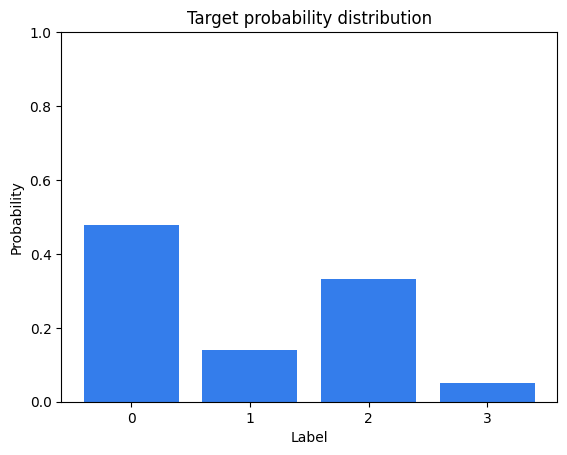

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_probability_distribution(probability_distribution, title='Probability distribution'):
    _, ax = plt.subplots()
    
    labels = [str(i) for i in range(len(probability_distribution))]
    ax.bar(labels, probability_distribution, color='#347deb', align='center')
    
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)


CPU times: user 16.3 ms, sys: 420 µs, total: 16.8 ms
Wall time: 20.1 ms


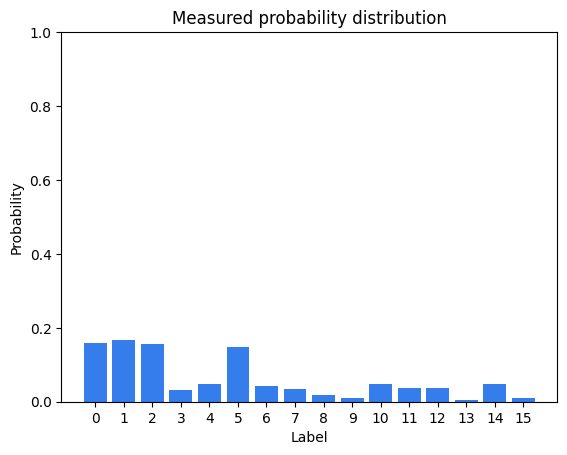

In [72]:
def measure_probability_distribution(parameters, backend, num_variables, num_qubits, num_shots=1024):
    """
    Sets up the quantum circuit with the given parameters, runs the experiment, and transforms the
    results measured from the experiment into a probability distribution.
    
    :param parameters: List of parameters that will be used when defining the circuit.
    :param num_shots: Number of times that the quantum algorithm will be executed.
    :return: The probability distribution vector associated to the results received from the quantum
        experiment. E.g.: [0.1329, 0.5671, 0.1000, 0.2000].
    """
    
    # Obtain a quantum circuit instance from the parameters
    circuit, _ = get_qcbm_circuit(n=num_variables, m=num_qubits, layers=1, parameters=parameters)
    circuit.measure_all()

    # Transpile the quantum circuit to map the topology of the backend.
    transpiled_circuit = transpile(circuit, backend)
    
    # Deliver the job to the vendor and get the identifier of that job back.
    # The circuit will be run for a given number of executions (shots).
    # We could now work on other tasks while the job gets executed remotely, or in the background -locally-.
    job = backend.run(transpiled_circuit, shots=num_shots)
    
    # Wait for the results to be ready, and obtain the probability distribution associated with the current
    # parameters
    result = job.result()

    # Obtain the counts for each measured state, and convert those counts into a probability vector
    total_qubits = num_qubits*num_variables
    counts = result.get_counts()
    length_string = len('{0:b}'.format(2**total_qubits - 1))
    for i in range(2**total_qubits):
        binary_label = '{0:b}'.format(i).zfill(length_string)
        if binary_label not in counts:
            counts[binary_label] = 0

    # Convert the dictionary of measurements into a probability distribution.
    output_distribution = [shots / num_shots for shots in counts.values()]
        
    return output_distribution

backend = BasicAer.get_backend('qasm_simulator')

sample_params = [[1,1,1], [1,1,1], [1,1]]
%time output_distribution = measure_probability_distribution(parameters=sample_params, backend=backend, num_qubits=2, num_variables=2)
plot_probability_distribution(output_distribution, title='Measured probability distribution')